In [1]:
#%reset -f -s

In [2]:
'''------------------------------------------------------------------
---------------------------------------------------------------------
LSTM Training
---------------------------------------------------------------------
Version: V1.7       Modified: 06.11.2024        William Siegle
---------------------------------------------------------------------
notebook can be converted to python script using: 
(python -m) jupytext --to py FILENAME.ipynb
------------------------------------------------------------------'''
from pathlib import Path

# SETTINGS ------------------------------------------------------------------------
CONFIG = {
    # SYSTEM: ---------------------------------------------------------------------
    "ROOT":             Path('../..').resolve(),
    "INPUT_LOCATION":   Path("TripSequences", "trips_processed_final"), 
    "OUTPUT_LOCATION":  Path("src", "models", "pth"),
    "GPU_SELECT":       0, # {0,1,2,3, None: CPU only}
    "TORCH_SEED"  :     42,

    # DATA PREPROCESSING: ---------------------------------------------------------
    "TRAIN_VAL_TEST":   [0.8, 0.15, 0.05], # [train, val, test splits]
    "MAX_FILES":        200, # None: all files
    "SCALERS":          {'feature_scaler': 'MaxAbsScaler()', 'target_scaler': 'MinMaxScaler(feature_range=(0, 1))'},

    # FEATURES: -------------------------------------------------------------------
    "FEATURES":         ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 'roadgrad_cval_pt', "vehweight_cval_pt", "accelpdlposn_cval", 
                         "bs_brk_cval", "elcomp_pwrcons_cval","epto_pwr_cval", "motortemperature_pti1", "powerstagetemperature_pti1", 'airtempinsd_cval_hvac', 
                         'brktempra_cval', 'selgr_rq_pt'],
    "TARGETS":          ['hv_bat_soc_cval_bms1'],

    # MODEL: -----------------------------------------------------------------------
    "HIDDEN_SIZE":      128,    # features in the hidden state h
    "NUM_LAYERS":       2,      # recurrent layers for stacked LSTMs. Default: 1
    "DROPOUT":          0.4,
    "SEQ_LENGTH":       60,
    
    # TRAINING & OPTIMIZER: --------------------------------------------------------
    "NUM_EPOCHS":       2,
    "BATCH_SIZE":       512,   # [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
    "LEARNING_RATE":    4e-4,   # 0.001 lr
    "OPTIMIZER":        "torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = 1e-4)",      
                            # weight_decay = 1e-4     # weight decay coefficient (default: 1e-2)
                            # betas = (0.9, 0.95),    # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
                            # eps = 1e-8,             # term added to the denominator to improve numerical stability (default: 1e-8)
    "LRSCHEDULER":      "torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 2, factor = 0.5, min_lr = 1e-6)",

    # LOSS FUNCTION: ---------------------------------------------------------------
    "CRITERION":        "nn.SmoothL1Loss()", #['nn.MSELoss()', 'nn.L1Loss()', 'nn.SmoothL1Loss()', 'nn.HuberLoss()', 'MASE()']

    # METRICS: ---------------------------------------------------------------------

    # SAVE & LOAD: -----------------------------------------------------------------
    
}

for key in CONFIG: globals()[key] = CONFIG[key]

___
LOCATE DEVICES & SYSTEM FOLDERS

In [ ]:
# LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  ---------------------------
# ----------------------------------------------------------------------------------------
import sys, os
global ROOT, DATA_PATH
if 'ROOT' not in globals(): ROOT = Path('../..').resolve()
print(f"{'-'*60}\nDirectories:\n  {ROOT}:\t\t\t{', '.join([_.name for _ in ROOT.glob('*/')])}")
sys.path.append(os.path.abspath(ROOT))
from data import get_data_path  # paths set in "data/__init__.py"
DATA_PATH = get_data_path()
print(f"  {DATA_PATH}:\t\t\t{', '.join([_.name for _ in DATA_PATH.glob('*/')])}")

# INTERNAL MODULE IMPORTS ----------------------------------------------------------------
# ----------------------------------------------------------------------------------------
from src.utils.TripDataset import *
from src.utils.train_model import *

# NOTEBOOK / SCRIPT SETTINGS -------------------------------------------------------------
# ----------------------------------------------------------------------------------------
global IS_NOTEBOOK
IS_NOTEBOOK = False
try:    # if running in IPython
    shell = get_ipython().__class__.__name__ # type: ignore 
    from IPython.display import display, HTML, Javascript, clear_output
    from IPython.core.magic import register_cell_magic
    @register_cell_magic    # cells can be skipped by using '%%skip' in the first line
    def skip(line, cell): return
    from tqdm.notebook import tqdm as tqdm_nb
    IS_NOTEBOOK = True
    print(f"{'-'*60}\nRunning in notebook mode")
except (NameError, ImportError):    # if running in script
    from tqdm import tqdm as tqdm
    from tabulate import tabulate
    print(f"{'-'*60}\nRunning in script mode")
    
# GENERAL MODULE IMPORTS -----------------------------------------------------------------
# ----------------------------------------------------------------------------------------
import math, time, random, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import pyarrow.parquet as pq
from copy import deepcopy
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline
#from sklearn.compose import ColumnTransformer
from scipy.signal import savgol_filter

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
from torch.nn.utils.rnn import pack_sequence, pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torchmetrics.functional import mean_squared_error
torch.set_default_dtype(torch.float32); torch.manual_seed(TORCH_SEED);

from sklearn.metrics import root_mean_squared_error
from pytorch_forecasting.metrics import MASE
#from darts import TimeSeries
#from darts.models import ExponentialSmoothing

------------------------------------------------------------
Directories:
  C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-eR-PINN:			.git, archive, data, project, ref, src, test
  C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data:			new_folder, OLD, processed, TripSequences
------------------------------------------------------------
Running in script mode


In [4]:
# DEVICE SELECTION ---------------------------------------------------------------------
global DEVICE
print(f"{'-'*60}\nTorch version: ", torch.__version__)
if not torch.cuda.is_available() or GPU_SELECT is None:
    DEVICE = torch.device("cpu")
else:
    DEVICE = torch.device(f"cuda:{GPU_SELECT}")
print(f"Using: -->  {str(DEVICE).upper()}")

------------------------------------------------------------
Torch version:  2.5.1+cpu
Using: -->  CPU


___
DATA PREPROCESSING

In [6]:
# FILE SOURCES ---------------------------------------------------------------
input_folder = Path(DATA_PATH, INPUT_LOCATION) # Trip parquet files
pth_folder = Path(ROOT, OUTPUT_LOCATION)
print(f"{'-'*60}\nInput Data:\t{input_folder}\nStore model in:\t{pth_folder}")

# PREPARE TRAIN & TEST SET ---------------------------------------------------
all_files = [Path(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".parquet")]
files = all_files[:MAX_FILES]
print(f"{'-'*60}\nTotal Files:\t{len(files)}")
# ---------------------------------------------------
df = pd.read_parquet(Path(input_folder, random.choice(files)), engine='fastparquet')
all_signals = df.columns
assert len(all_signals) == 44

# FILTER INPUT FILES --------------------------------------------------------
# Filter files based on row count 
filtered_files = []
trip_lengths = []
for file in files:
    trip_rows = pq.read_metadata(file).num_rows
    if trip_rows >= 600:
        trip_lengths.append(trip_rows)
        filtered_files.append(file)

files = filtered_files
print(f"Filtered Files:\t{len(files)}\n{'-'*60}")
file_length_mapping = sorted([(file.name, length) for file, length in zip(filtered_files, trip_lengths) if file in filtered_files], key=lambda x: x[1], reverse=True)
file_length_df = pd.DataFrame(file_length_mapping, columns=['File Name', 'Length'])
print(file_length_df)

------------------------------------------------------------
Input Data:	C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\TripSequences\trips_processed_final
Store model in:	C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-eR-PINN\src\models\pth
------------------------------------------------------------
Total Files:	200
Filtered Files:	153
------------------------------------------------------------


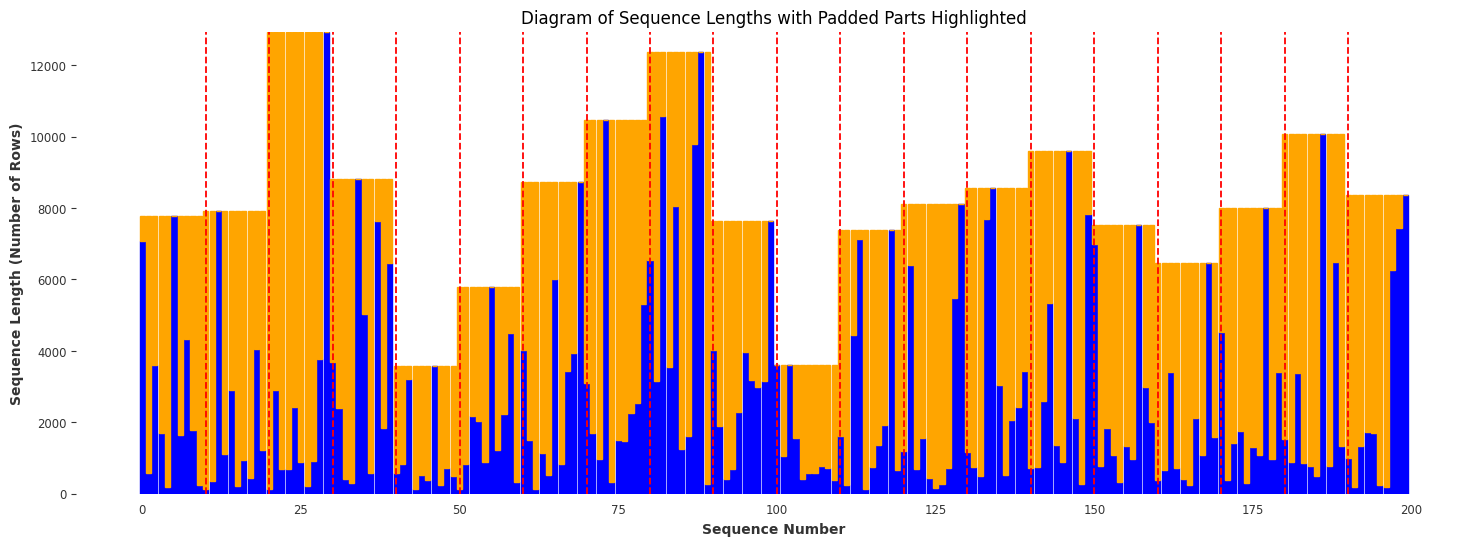

Blue/Orange Ratio = 0.33


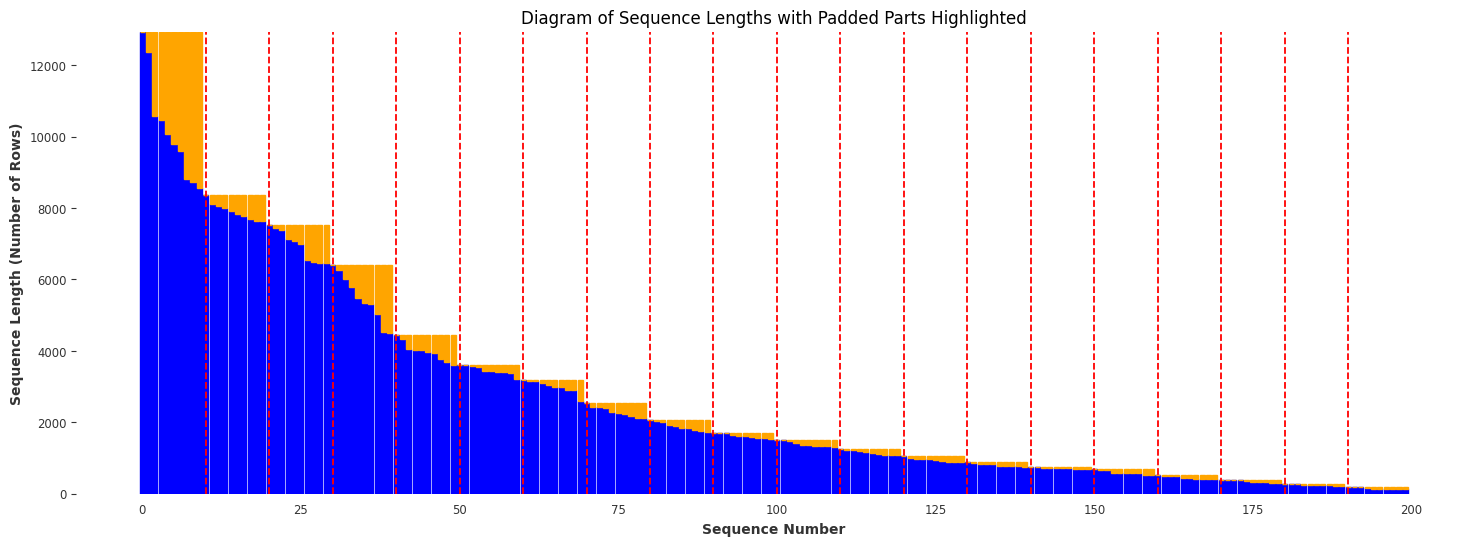

Blue/Orange Ratio = 0.90


In [7]:
# Sort the trip lengths in descending order
sorted_trip_lengths = sorted(trip_lengths, reverse=True)

# Define the batch size
batch_size = 10
# Calculate the number of batches
num_batches = int(np.ceil(len(sorted_trip_lengths) / batch_size))
#########################################################################
# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 6))
# Plot each batch
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(trip_lengths))
    batch_lengths = trip_lengths[start_idx:end_idx]
    
    # Plot the actual sequence lengths
    ax.bar(range(start_idx, end_idx), batch_lengths, color='blue', edgecolor='blue')
    
    # Highlight the padded parts
    max_length = max(batch_lengths)
    for j in range(start_idx, end_idx):
        ax.bar(j, max_length - batch_lengths[j - start_idx], bottom=batch_lengths[j - start_idx], color='orange', edgecolor='orange')

    # Add vertical red dashed lines at batch boundaries
    if i > 0:
        ax.axvline(x=start_idx, color='red', linestyle='--')

# Set labels and title
ax.set_xlabel('Sequence Number')
ax.set_ylabel('Sequence Length (Number of Rows)')
ax.set_title('Diagram of Sequence Lengths with Padded Parts Highlighted')
ax.grid(False); plt.show();

# Calculate and print the ratio between blue and orange areas for both diagrams
ratios_1 = []
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(trip_lengths))
    batch_lengths = trip_lengths[start_idx:end_idx]
    max_length = max(batch_lengths)
    blue_area = sum(batch_lengths)
    orange_area = sum(max_length - length for length in batch_lengths)
    ratio = blue_area / (blue_area + orange_area)
    ratios_1.append(ratio)
mean_ratio_1 = np.mean(ratios_1)
print(f"Blue/Orange Ratio = {mean_ratio_1:.2f}")


########################################################################
# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 6))
# Plot each batch
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(sorted_trip_lengths))
    batch_lengths = sorted_trip_lengths[start_idx:end_idx]
    
    # Plot the actual sequence lengths
    ax.bar(range(start_idx, end_idx), batch_lengths, color='blue', edgecolor='blue')
    
    # Highlight the padded parts
    max_length = max(batch_lengths)
    for j in range(start_idx, end_idx):
        ax.bar(j, max_length - batch_lengths[j - start_idx], bottom=batch_lengths[j - start_idx], color='orange', edgecolor='orange')

    # Add vertical red dashed lines at batch boundaries
    if i > 0:
        ax.axvline(x=start_idx, color='red', linestyle='--')

# Set labels and title
ax.set_xlabel('Sequence Number')
ax.set_ylabel('Sequence Length (Number of Rows)')
ax.set_title('Diagram of Sequence Lengths with Padded Parts Highlighted')
ax.grid(False); plt.show();

ratios_2 = []
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(sorted_trip_lengths))
    batch_lengths = sorted_trip_lengths[start_idx:end_idx]
    max_length = max(batch_lengths)
    blue_area = sum(batch_lengths)
    orange_area = sum(max_length - length for length in batch_lengths)
    ratio = blue_area / (blue_area + orange_area)
    ratios_2.append(ratio)
mean_ratio_2 = np.mean(ratios_2)
print(f"Blue/Orange Ratio = {mean_ratio_2:.2f}")

In [8]:
# INPUT & TARGET SPECIFICATION ---------------------------------------------------
# these signals are required for the physical Model calculation:
base_signals = ["signal_time", "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 
"hv_batpwr_cval_bms1", "emot_pwr_cval","bs_roadincln_cval", "roadgrad_cval_pt"]

# these signals have to be dropped in order for appropriate training:
columns_to_drop = ["hv_batmomavldischrgen_cval_1", "latitude_cval_ippc", "longitude_cval_ippc", "signal_time"]

# ---------------------------------------------------
selection_1 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 'roadgrad_cval_pt', "vehweight_cval_pt", "accelpdlposn_cval", "bs_brk_cval", "elcomp_pwrcons_cval",
               "epto_pwr_cval", "motortemperature_pti1", "powerstagetemperature_pti1", 'airtempinsd_cval_hvac', 'brktempra_cval', 'selgr_rq_pt']
selection_2 = ["hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "hv_batpwr_cval_bms1", "emot_pwr_cval","bs_roadincln_cval", "roadgrad_cval_pt"]
selection_3 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "bs_roadincln_cval", "vehweight_cval_pt"]

In [9]:
# ---------------------------------------------------
target_column = TARGETS
input_columns = FEATURES

# FEATURE NORMALIZATION/SCALING -----------------------------------------------------------------
scaler = eval(SCALERS['feature_scaler'])
target_scaler = eval(SCALERS['target_scaler'])
# ---------------------------------------------------
# Common Scalers: MinMaxScaler(feature_range=(0, 1)), StandardScaler(), MaxAbsScaler(), RobustScaler(), QuantileTransformer(), PowerTransformer()

# DATA SET SPLITTING -----------------------------------------------------------------------
# train_subset, test_subset = train_test_split(files, test_size=0.2, random_state=1)
train_subset, val_subset, test_subset = random_split(files, TRAIN_VAL_TEST)

In [ ]:
# GENERATE DATALOADERS  ---------------------------------------------------------------
# Note: 1. the scaler will be fitted only on the training data set
#       2. shuffling is prohibited to maintain the time series order

# TRAIN  ------------------------------------------------------------
train_dataset = TripDataset(train_subset, input_columns, target_column, scaler, target_scaler, fit=True)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=False)

# VAL ------------------------------------------------------------
val_dataset = TripDataset(val_subset, input_columns, target_column, scaler, target_scaler, fit=False)
val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False)

# TEST ------------------------------------------------------------
test_dataset = TripDataset(test_subset, input_columns, target_column, scaler, target_scaler, fit=False)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)

# Print the size of the datasets ----------------------------------
print(f"{'-'*60}\nTrain size:  {len(train_dataset)}\t\t(Files: {len(train_subset)})")
print(f'Val. size:   {len(val_dataset)}\t\t(Files: {len(val_subset)})')
print(f'Test size:   {len(test_dataset)}\t\t(Files: {len(test_subset)}) \n {"-"*60}')
if train_dataset.__len__() != sum(len(data) for data in train_dataset.data): print("Warning: Train Dataset Length Mismatch")

subset_files = {"train":    list(train_loader.dataset.file_list),
                "val":      list(val_loader.dataset.file_list),
                "test":     list(test_loader.dataset.file_list)}
print(f"first 3 train files: {[os.path.basename(_) for _ in subset_files['train'][:3]]}")

fitting Scalers: MaxAbsScaler, MinMaxScaler
Done. Create DataSets...
------------------------------------------------------------
Train size:  399005		(Files: 123)
Val. size:   82492		(Files: 23)
Test size:   38585		(Files: 7) 
 ------------------------------------------------------------
first 3 train files: ['V101_T258.parquet', 'V101_T168.parquet', 'V101_T27.parquet']


___
NETWORK ARCHITECTURE

In [ ]:
# LSTM NETWORK -----------------------------------------------------------------------
class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length, dropout, device = DEVICE):
        super(LSTM1, self).__init__()

        self.input_size = input_size    # input size
        self.hidden_size = hidden_size  # hidden state
        self.num_layers = num_layers    # number of layers
        self.dropout = dropout
        #self.num_classes = num_classes  # number of classes
        self.seq_length = seq_length    # sequence length

        # LSTM CELL --------------------------------
        self.lstm = nn.LSTM(
            self.input_size,            # The number of expected features in the input x
            self.hidden_size,           # The number of features in the hidden state h
            self.num_layers,            # Number of recurrent layers for stacked LSTMs. Default: 1
            batch_first = True,         # If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Default: False
            bias = True,                # If False, then the layer does not use bias weights b_ih and b_hh. Default: True
            dropout = self.dropout,     # usually: [0.2 - 0.5] ,introduces a Dropout layer on the outputs of each LSTM layer except the last layer, (dropout probability). Default: 0
            bidirectional = False,      # If True, becomes a bidirectional LSTM. Default: False
            proj_size = 0,              # If > 0, will use LSTM with projections of corresponding size. Default: 0
            device = DEVICE) 
        
        # --------------------------------
        #self.fc_1 =  nn.Linear(hidden_size, 128)  # fully connected 1
        #self.fc = nn.Linear(128, num_classes)     # fully connected last layer
        # --------------------------------
        self.relu = nn.ReLU()
        self.fc_test =  nn.Linear(hidden_size, 1)

    
    def forward(self, input, batch_size = None):
        '''        
        # initial hidden and internal states
        # --------------------------------
        h_0 = torch.zeros(self.num_layers, input.size(0) if batch_size is None else batch_size, self.hidden_size)
        c_0 = torch.zeros(self.num_layers, input.size(0) if batch_size is None else batch_size, self.hidden_size)  
        # --------------------------------
        out = self.relu(hn.view(-1, self.hidden_size)) # reshaping the data for Dense layer next
        out = self.fc_1(out) # first Dense
        out = self.relu(out) # relu
        out = self.fc(out) # Final Output
        '''

        # Propagate input through LSTM
        # --------------------------------
        # output, (hn, cn) = self.lstm(input, (h_0, c_0)) # lstm with input, hidden, and internal state
        # input shape:      (batch_size, seq_length, input_size)
        # output shape:     (batch_size, seq_length, hidden_size)
        # --------------------------------
        out, _ = self.lstm(input)


        # ouput layers
        # --------------------------------
        out = self.relu(out) # relu
        out = self.fc_test(out[:, -1, :])  
        #out = self.fc_test(out)

        return out 

In [14]:
# FCNN NETWORK -----------------------------------------------------------------------
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        
        # here, our linear layer will have an input of 200, not 100 as before:
        self.fc1 = nn.Linear(200,5)  
        self.fc2 = nn.Linear(5,10)   
        self.fc3 = nn.Linear(10,100) # but the output remains 100
        
          
    def forward(self, x):
        # we have to flatten our 20x2x100 to a 20x200:
        x = x.view(x.size(0),-1)     # x.size(0) is 20, and -1 is a shortcut for "figure out the other number for me please!"
        
        # the rest proceeds as before:
        x = F.relu(self.fc1(x))      
        x = F.relu(self.fc2(x))
        x = self.fc3(x)              
        return x
        
#net = FCNN()
#print(net) 

In [15]:
# MODEL CONFIGURATION -----------------------------------------------------------------------

# LAYERS --------------------------------
input_size = len(input_columns)     # expected features in the input x
hidden_size = HIDDEN_SIZE           # features in the hidden state h
num_layers = NUM_LAYERS             # recurrent layers for stacked LSTMs. Default: 1
num_classes = 1                     # output classes (=1 for regression)

# INSTANTIATE MODEL --------------------
model = LSTM1(input_size, HIDDEN_SIZE, NUM_LAYERS, SEQ_LENGTH, DROPOUT).to(DEVICE)
print(f"{'-'*60}\n", model)

------------------------------------------------------------
 LSTM1(
  (lstm): LSTM(14, 128, num_layers=2, batch_first=True, dropout=0.4)
  (relu): ReLU()
  (fc_test): Linear(in_features=128, out_features=1, bias=True)
)


___
TRAINING SETUP

In [16]:
# TRAINING CONFIGURATION -----------------------------------------------------------------------

# OPTIMIZER -----------------------------
# common optimizers: ['torch.optim.Adam', 'torch.optim.SGD', 'torch.optim.RMSprop']
if 'OPTIMIZER' in globals(): optimizer = eval(OPTIMIZER)
else:
    optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE,
        weight_decay = 1e-4      # weight decay coefficient (default: 1e-2)
        #betas = (0.9, 0.95),    # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
        #eps = 1e-8,             # term added to the denominator to improve numerical stability (default: 1e-8)
)

# LR SCHEDULER -----------------------------
if 'LRSCHEDULER' in globals(): scheduler = eval(LRSCHEDULER)
else: scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 2, factor = 0.5, min_lr = 1e-6)

# LOSS FUNCTION ----------------------------------------------------------------
def loss_fn(model_output, target):
    loss = F.mse_loss(model_output, target) # mean-squared error for regression
    return loss

# or define criterion function:
criterion_list = [nn.MSELoss(), nn.L1Loss(), nn.SmoothL1Loss(), nn.HuberLoss(), MASE()]

if 'CRITERION' in globals(): criterion = eval(CRITERION)
else: criterion = nn.SmoothL1Loss()

# ------------------------------------------------------------------------------
# print Model and Optimizer state_dicts
print(f"{'-'*60}\nModel state_dict:")
for param_tensor in model.state_dict(): print(f"{param_tensor}:\t {model.state_dict()[param_tensor].size()}")
print(f"{'-'*60}\n{optimizer}\n{'-'*60}\n")

------------------------------------------------------------
Model state_dict:
lstm.weight_ih_l0:	 torch.Size([512, 14])
lstm.weight_hh_l0:	 torch.Size([512, 128])
lstm.bias_ih_l0:	 torch.Size([512])
lstm.bias_hh_l0:	 torch.Size([512])
lstm.weight_ih_l1:	 torch.Size([512, 128])
lstm.weight_hh_l1:	 torch.Size([512, 128])
lstm.bias_ih_l1:	 torch.Size([512])
lstm.bias_hh_l1:	 torch.Size([512])
fc_test.weight:	 torch.Size([1, 128])
fc_test.bias:	 torch.Size([1])
------------------------------------------------------------
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0004
    maximize: False
    weight_decay: 0.0001
)
------------------------------------------------------------



___
NETWORK TRAINING

In [ ]:
# NETWORK TRAINING -----------------------------------------------------------------
trainer = Trainer(
    model = model, 
    optimizer = optimizer,
    scheduler = scheduler, 
    loss_fn = criterion, 
    train_loader = train_loader,
    val_loader = val_loader, 
    num_epochs = NUM_EPOCHS, 
    device = DEVICE, 
    is_notebook = IS_NOTEBOOK,
    use_mixed_precision = True
    )
    
trained = trainer.train_model()

------------------------------------------------------------
Training Started.	Process ID: 23192 
------------------------------------------------------------
Model: LSTM1		Parameters on device: CPU
------------------------------------------------------------
Train/Batch size:	399005 / 512
Loss:			SmoothL1Loss()
Optimizer:		AdamW
LR:			0.0004
Weight Decay:		0.0001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/780 [00:00<?, ?batch/s]

  0%|          | 0/780 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:00:57



In [ ]:
# COLLECTING RESULTS AND META DATA ---------------------------------------------------
trained['CONFIG'] = CONFIG
trained['subset_files'] = subset_files

In [24]:
# SAVE   -----------------------------------------------------------------
# create unique model name
model_name = f'{model.__class__.__name__}_{datetime.now().strftime("%y%m%d_%H%M%S")}'
model_destination_path = Path(pth_folder, model_name + ".pth")

# save object & print info
torch.save(trained, model_destination_path)
print(f"Model saved to:\t {model_destination_path}\n{'-'*60}\nSize: {os.path.getsize(model_destination_path) / 1024**2:.2f} MB\n{'-'*60}")
if os.path.getsize(model_destination_path) > 100 * 1024**2: print("--> Warning: The saved model size exceeds 100MB!")

Model saved to:	 C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-eR-PINN\src\models\pth\LSTM1_241126_115610.pth
------------------------------------------------------------
Size: 2.39 MB
------------------------------------------------------------


In [ ]:
# LOAD FROM CHECKPOINT -----------------------------------------------------------------
#model_destination_path = Path(pth_folder, "LSTM1_241118_184156.pth")

# -----------------------------------------------------------------
checkpoint = torch.load(model_destination_path, weights_only=False, map_location=DEVICE if torch.cuda.is_available() else torch.device('cpu'))
for key in ["model", "loss_fn", "training_table", "train_losses", "val_losses", "epoch"]: exec(f"{key} = checkpoint[key]")

# configure model and optimizer:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Move the model and its parameters to the CPU
try:
    if torch.cuda.is_available() and GPU_SELECT is not None:
        model.to(DEVICE)
    else:
        model.to(torch.device("cpu"))
except:
    model.to(torch.device("cpu"))

model.eval(); # set model to evaluation mode for inference
print(f"Model loaded from:\t {model_destination_path}\n{'-'*60}")
print(f"Model: {model.__class__.__name__}\t\tParameters on device: {next(model.parameters()).device}\n{'-'*60}\n"
        f"Train/Batch size:\t{len(train_loader.dataset)} / {train_loader.batch_size}\n"
        f"Loss:\t\t\t{loss_fn}\nOptimizer:\t\t{optimizer.__class__.__name__}\nLR:\t\t\t"
        f"{optimizer.param_groups[0]['lr']}\nWeight Decay:\t\t{optimizer.param_groups[0]['weight_decay']}\n{'-'*60}\n", model)

# get file list of test subset
test_files = checkpoint["subset_files"]["test"]

Model loaded from:	 C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-eR-PINN\src\models\pth\LSTM1_241126_104104.pth
------------------------------------------------------------
Model: LSTM1		Parameters on device: cpu
------------------------------------------------------------
Train/Batch size:	399005 / 512
Loss:			SmoothL1Loss()
Optimizer:		AdamW
LR:			0.005
Weight Decay:		0.0001
------------------------------------------------------------
 LSTM1(
  (lstm): LSTM(14, 128, num_layers=2, batch_first=True, dropout=0.4)
  (relu): ReLU()
  (fc_test): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
# RESUME TRAINING -----------------------------------------------------------------
resume = True
if resume: 
    NUM_EPOCHS += 2 # train for 2 more epochs
    trainer = Trainer(
        model = model, 
        optimizer = optimizer,
        scheduler = scheduler, 
        loss_fn = criterion, 
        train_loader = train_loader,
        val_loader = val_loader, 
        state = checkpoint,
        num_epochs = NUM_EPOCHS, 
        device = DEVICE, 
        is_notebook = IS_NOTEBOOK)
    trained_2 = trainer.train_model()


------------------------------------------------------------
Training Started.	Process ID: 42292 
------------------------------------------------------------
Model: LSTM1		Parameters on device: CPU
------------------------------------------------------------
Train/Batch size:	399005 / 512
Loss:			SmoothL1Loss()
Optimizer:		AdamW
LR:			0.005
Weight Decay:		0.0001
------------------------------------------------------------


  0%|          | 0/780 [00:00<?, ?batch/s]

  0%|          | 0/780 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:01:18



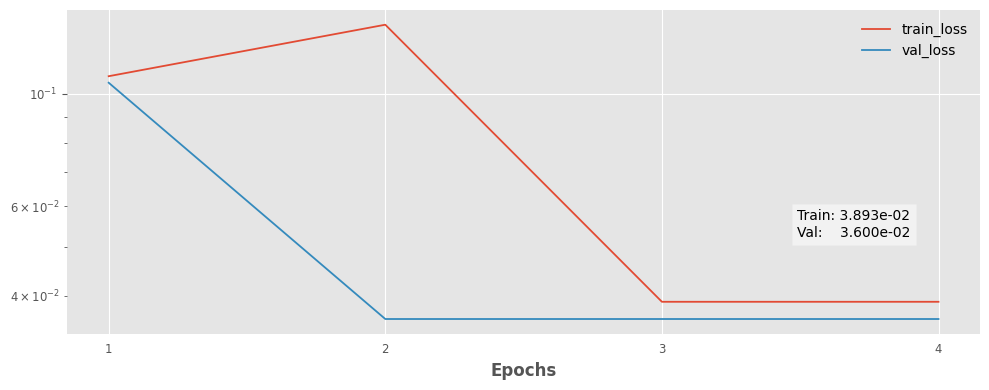

In [ ]:
# get DataFrame of training metrics:
training_df = pd.DataFrame(training_table, columns=["Epoch", "Iteration", "Batch Loss", "Train Loss"])
# Extract the 'Train Loss' column and compare with the train_losses list
train_loss_column = training_df['Train Loss'].replace(['',' '], np.nan).dropna().astype(float).values
if any(abs(train_loss_column - train_losses) > 1e-3): 
    print("Extracted and original Train Losses are not equal. Please check metrics table.")

# -------------------------------------
# plot training performance:
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.set_xlabel('Epochs')
ax1.set_xticks(range(1, NUM_EPOCHS + 1))

plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='train_loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='val_loss')
plt.yscale('log'); fig.tight_layout(); plt.legend();

plt.text(0.8, 0.3, f"Train: {train_losses[-1]:.3e}\nVal:    {val_losses[-1]:.3e}", transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5));

___
EVALUATION / POST-PROCESSING

In [ ]:
# EVALUATION -----------------------------------------------------------------
model.eval() # set model to evaluation mode
test_loss = 0
all_outputs, all_targets = [], []

with torch.no_grad():
    for iter, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)

        # Collect all outputs and targets
        all_outputs.append(outputs.detach().cpu().numpy())
        all_targets.append(targets.detach().cpu().numpy())

        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item()

# Inverse-transform on all outputs and targets for evaluation
scaled_outputs = target_scaler.inverse_transform(np.concatenate(all_outputs, axis=0).reshape(-1, 1))
scaled_targets = target_scaler.inverse_transform(np.concatenate(all_targets, axis=0).reshape(-1, 1))


test_loss /= len(test_loader)
print(f"Test Loss:  {test_loss:.4f}")
print(f"Iterations: {iter}/{math.floor(len(test_loader.dataset) / test_loader.batch_size)}")
print(f"RMSE: {root_mean_squared_error(scaled_targets, scaled_outputs):.4f}")
print(f"Standard Deviation: {np.std(scaled_targets - scaled_outputs):.4f}")

Test Loss:  0.3063
Iterations: 75/75
RMSE: 71.4654
Standard Deviation: 16.0176


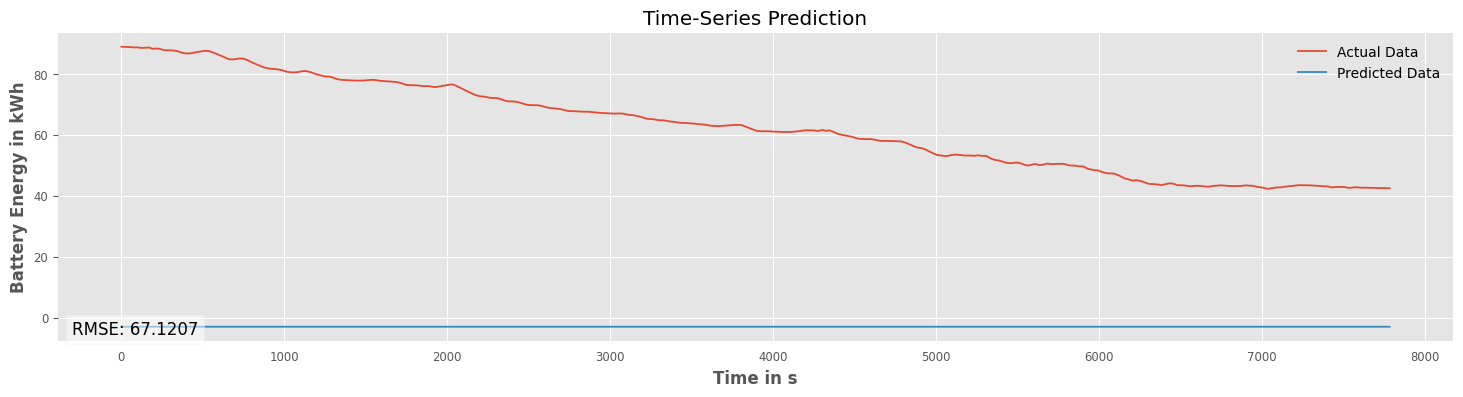

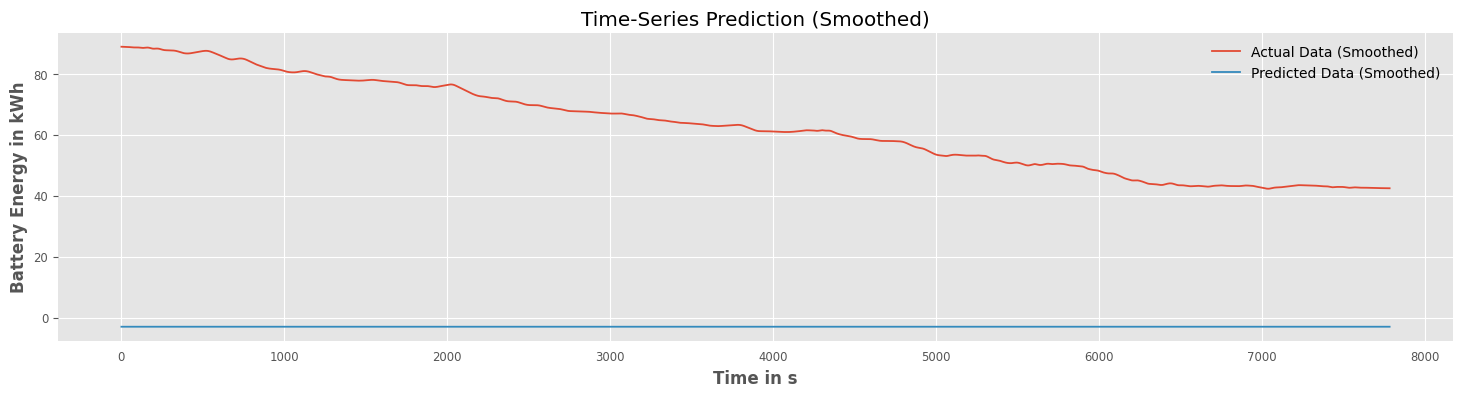

In [ ]:
test_dataset = TripDataset(random.sample(test_files, 1), input_columns, target_column, scaler, target_scaler, fit=False)
test_loader_2 = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
y_pred = []
with torch.no_grad():
    for inputs, targets in test_loader_2:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)
        y_pred.append(torch.mean(outputs).item())

y_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_true = target_scaler.inverse_transform(np.array(test_loader_2.dataset.targets[0]).reshape(-1, 1))

###############################################
# PLOT PREDICTION -----------------------------------------------------------------
plt.figure(figsize=(18,4)); plt.xlabel('Time in s'); plt.ylabel('Battery Energy in kWh'); plt.title('Time-Series Prediction')
plt.plot(y_true, label='Actual Data') # actual plot
plt.plot(np.arange(0, len(y_true), 1), y_pred, label='Predicted Data') # predicted plot
plt.legend()
plt.text(0.01, 0.02, f"RMSE: {root_mean_squared_error(y_true, y_pred):.4f}", transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.figure(figsize=(18,4)); plt.xlabel('Time in s'); plt.ylabel('Battery Energy in kWh'); plt.title('Time-Series Prediction (Smoothed)')
plt.plot(savgol_filter(y_true.flatten(), window_length=60, polyorder=3), label='Actual Data (Smoothed)') # actual plot
plt.plot(np.arange(0, len(y_true), 1), savgol_filter(y_pred.flatten(), window_length=60, polyorder=3), label='Predicted Data (Smoothed)') # predicted plot
plt.legend();